**Project 2**

Using data from QSAR Fish Toxicity [research](https://archive.ics.uci.edu/ml/datasets/QSAR+fish+toxicity), make polynomial models of degree 1, 2, and 3 and determine which degree achieves the best external validation. Use regularized regression models (Ridge, Lasso, Elastic Net), and determine best value of hyperparameter alpha in each case. [For Elastic Net, assume the L1 ratio hyperparameter is 0.5.] 

Compare the residuals of the best model on the entire dataset and determine if they follow a normal distribution.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import r2_score, mean_squared_error as mse
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from scipy import stats
import statsmodels.api as sm

import warnings
warnings.simplefilter(action='ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


##Define functions for model testing, comparing alpha values, plotting model results

In [ ]:
def test_model(X,y,model,k,d,random_state=123):
  '''
  The test_model function evaluates the accuracy of the input regression model.

  Inputs: 
    X = data for explanatory features
    y = dependent/target features
    model = regularization type (Lasso, Ridge, Elastic Net, etc.)
    k = number of folds for k-fold cross-validation
    d = degree for polynomial features
    random_state = (default = 123)

  Returns: 
    Mean of R^2 training values
    Mean of R^2 testing values
    Mean of MSE training values
    Mean of MSE testing values
  '''
  
  # set up cross-validation
  kf = KFold(n_splits=k, shuffle=True)
  # track internal and external validation, R^2
  R2train = []
  R2test = []
  # track internal and external validation, MSE 
  msetrain = []
  msetest = []

  # pipeline for preprocessing (scaling, polynomial features)
  ss = StandardScaler()
  poly = PolynomialFeatures(degree=d)
  pipe = Pipeline([['Scaling',ss],['Polynomial Features',poly]])

  for idxtrain, idxtest in kf.split(X):
    # create input features
    xtrain = X[idxtrain]
    xtest = X[idxtest]
    ytrain = y[idxtrain]
    ytest = y[idxtest]
    # apply pipeline to input features
    xpoly_train = pipe.fit_transform(xtrain)
    xpoly_test = pipe.transform(xtest)

    model.fit(xpoly_train,ytrain)
    # track R^2 values
    R2train.append(model.score(xpoly_train,ytrain))
    R2test.append(model.score(xpoly_test,ytest))
    # track MSE values
    msetrain.append(mse(ytrain,model.predict(xpoly_train)))
    msetest.append(mse(ytest,model.predict(xpoly_test)))

  return  np.mean(R2train), np.mean(R2test), np.mean(msetrain), np.mean(msetest),


def plot_model_results(training_scores,testing_scores, num_digits=4):

  '''
  Plotting the coefficients of determination to compare train/test accuracy
  
  Inputs: 
    training_scores = List of internal validation R^2 values when determining hyperparameter alpha 
    testing_scores = List of external validation R^2 values when determining hyperparameter alpha
    num_digits = number of digits to round training_scores, testing_scores (default=4)
  '''
  
  training_scores = np.round(training_scores, num_digits)
  testing_scores = np.round(testing_scores, num_digits)
  
  plt.figure(figsize=(6,6))
  plt.scatter(training_scores,testing_scores,alpha=0.5,ec='k')
  #axes labels calculate mean of training, testing scores
  plt.xlabel('Training $R^2=$' + format(np.mean(training_scores),'.'+ str(num_digits)+'f'))
  plt.ylabel('Testing $R^2=$' + format(np.mean(testing_scores),'.'+str(num_digits)+'f'))
  plt.axis('equal')
  plt.show()
  return

def compare_alpha(a_range, train, test, plot_test = True, plot_train = None): 
  '''
  compare_alpha plots a range of alpha values against the R^2 values for the training and testing set

  Inputs: 
    a_range = list of the range of alpha values
    train = list of R^2 values generated by internal validation
    test = list of R^2 values generated by external validation
    plot_test = When True, plots test values (default = True)
    plot_train = When not None, plots train values (default = None)

  '''
  plt.figure(figsize=(12,6))
  if plot_train != None: 
    plt.plot(a_range, train, '-k', label='Training')
  if plot_test != False:
    plt.plot(a_range, test, '-r', label='Testing')
  plt.xlabel('$\\alpha$')
  plt.ylabel('Avg. $R^2$')
  plt.legend()
  plt.show()

  idx_max = np.argmax(test)
  print('Highest training score, highest testing score, alpha:', [train[idx_max], test[idx_max], a_range[idx_max]])

# Data preprocessing

Importing data from https://archive.ics.uci.edu/ml/datasets/QSAR+fish+toxicity and preparing it for analysis

In [ ]:
data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00504/qsar_fish_toxicity.csv', sep = ';',header=None)
#add column labels to data
data.columns = ['CIC0','SM1_Dz(Z)','GATS1i','NdsCH','NdssC','MLOGP','LC50 [-LOG(mol/L)]]']

In [ ]:
data

,CIC0,SM1_Dz(Z),GATS1i,NdsCH,NdssC,MLOGP,LC50 [-LOG(mol/L)]]
0,3.260,0.829,1.676,0,1,1.453,3.770
1,2.189,0.580,0.863,0,0,1.348,3.115
2,2.125,0.638,0.831,0,0,1.348,3.531
3,3.027,0.331,1.472,1,0,1.807,3.510
4,2.094,0.827,0.860,0,0,1.886,5.390
...,...,...,...,...,...,...,...
903,2.801,0.728,2.226,0,2,0.736,3.109
904,3.652,0.872,0.867,2,3,3.983,4.040
905,3.763,0.916,0.878,0,6,2.918,4.818
906,2.831,1.393,1.077,0,1,0.906,5.317


In [ ]:
# X is a dataframe containing explanatory variables
# y is the dependent variable
X = data.iloc[:,:6]
y = data.iloc[:,-1:]

# Polynomial models

Determine which model (degree = 1, 2, or 3) yields the highest external validation.

## Degree = 1 

### Ridge regularization

In [ ]:
#test range of alpha
#a_range = np.arange(0.5,1,0.001)
a_range = np.arange(23,25,.01) 
#a_range = (0,10,1)

k = 10 

# track internal, external validation
R2internal = []
R2external = []
MSEinternal = []
MSEexternal = []

# test values of alpha
for a in a_range: 
  model = Ridge(alpha=a, fit_intercept=False)
  R2train_temp, R2test_temp, MSEtrain_temp, MSEtest_temp = test_model(X.values,y.values,model,k,1)
  R2internal.append(np.mean(R2train_temp))
  R2external.append(np.mean(R2test_temp))
  MSEinternal.append(np.mean(MSEtrain_temp))
  MSEexternal.append(np.mean(MSEtest_temp))

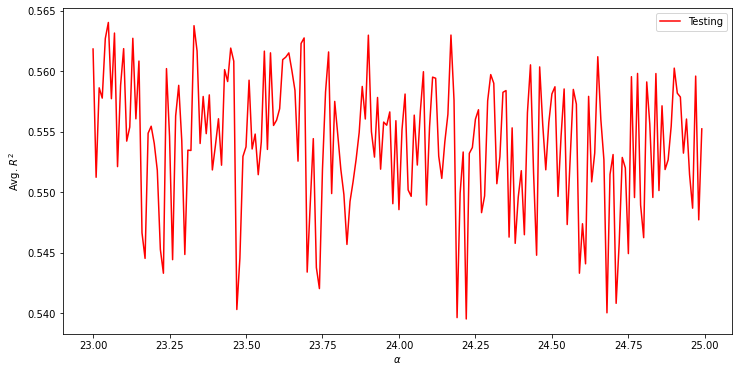

Highest training score, highest testing score, alpha: [0.5714175506024989, 0.5640271881810724, 23.050000000000008]


In [ ]:
compare_alpha(a_range,R2internal,R2external)

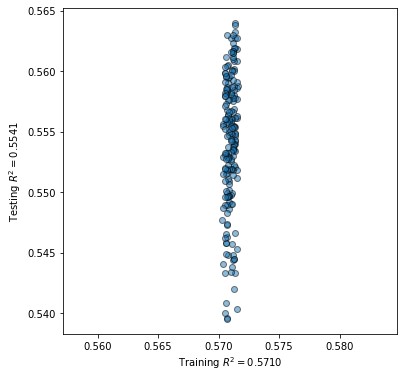

In [ ]:
plot_model_results(R2internal,R2external)

In [ ]:
# fit final model
idx_max = np.argmax(R2external)
model = Ridge(alpha=a_range[idx_max], fit_intercept=False)
R2train, R2test, MSEtrain, MSEtest = test_model(X.values,y.values,model,10,1)

In [ ]:
# calculate mean training, mean testing R^2
rid1 = [np.mean(R2train), np.mean(R2test)]
rid1

[0.5713928819998757, 0.5501656549951657]

### Lasso regularization

In [ ]:
#test range of alpha
a_range = np.arange(1e-3,0.01,.0001)
k = 10 

# track internal, external validation
R2internal = []
R2external = []
MSEinternal = []
MSEexternal = []

# test values of alpha
for a in a_range: 
  model = Lasso(alpha=a, fit_intercept=False)
  R2train_temp, R2test_temp, MSEtrain_temp, MSEtest_temp = test_model(X.values,y.values,model,k,1)
  R2internal.append(np.mean(R2train_temp))
  R2external.append(np.mean(R2test_temp))
  MSEinternal.append(np.mean(MSEtrain_temp))
  MSEexternal.append(np.mean(MSEtest_temp))

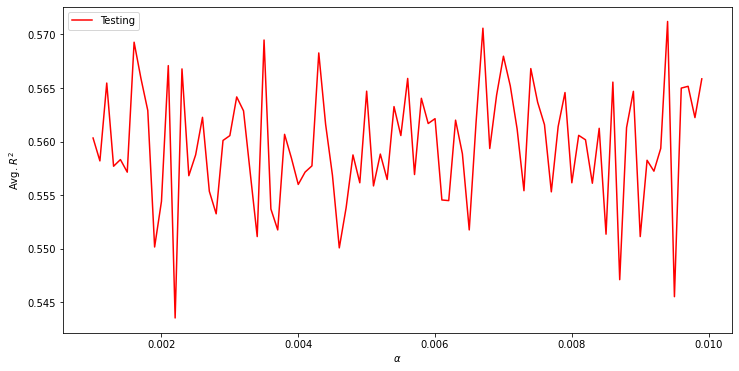

Highest training score, highest testing score, alpha: [0.5774533300559088, 0.5712178221997561, 0.009400000000000006]


In [ ]:
compare_alpha(a_range,R2internal,R2external)

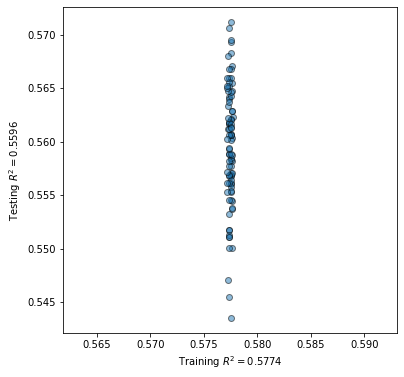

In [ ]:
plot_model_results(R2internal,R2external)

In [ ]:
# fit final model
idx_max = np.argmax(R2external)
model = Lasso(alpha=a_range[idx_max])
R2train, R2test, MSEtrain, MSEtest = test_model(X.values,y.values,model,10,1)

In [ ]:
# calculate mean training, mean testing R^2
las1= [np.mean(R2train), np.mean(R2test)]
las1

[0.5773465234169441, 0.565560900930541]

### Elastic Net regularization

In [ ]:
#test range of alpha
a_range = np.arange(1e-3,0.02,.001)
k = 10 

# track internal, external validation
R2internal = []
R2external = []
MSEinternal = []
MSEexternal = []

# test values of alpha
for a in a_range: 
  model = ElasticNet(alpha=a, fit_intercept=False)
  R2train_temp, R2test_temp, MSEtrain_temp, MSEtest_temp = test_model(X.values,y.values,model,k,1)
  R2internal.append(np.mean(R2train_temp))
  R2external.append(np.mean(R2test_temp))
  MSEinternal.append(np.mean(MSEtrain_temp))
  MSEexternal.append(np.mean(MSEtest_temp))

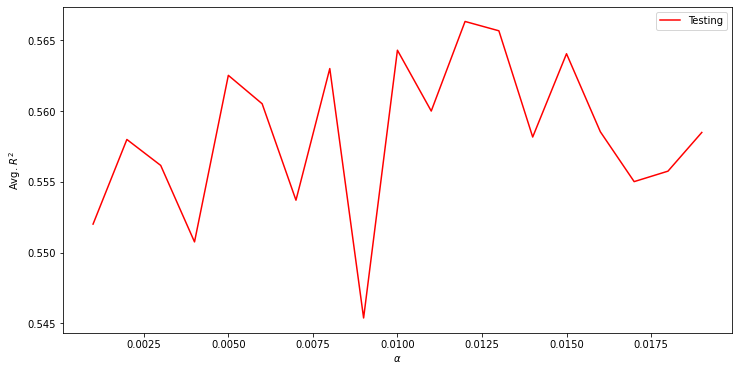

Highest training score, highest testing score, alpha: [0.5769574163129585, 0.5663349936142226, 0.012]


In [ ]:
compare_alpha(a_range,R2internal,R2external)

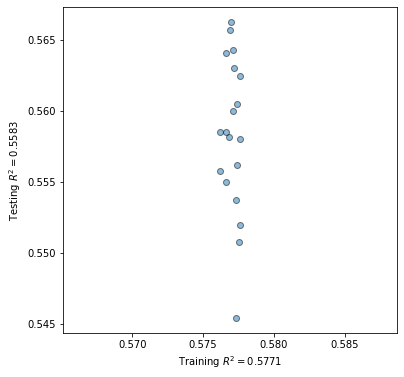

In [ ]:
plot_model_results(R2internal,R2external)

In [ ]:
# fit final model
idx_max = np.argmax(R2external)
model = ElasticNet(alpha=a_range[idx_max], fit_intercept=False)
R2train, R2test, MSEtrain, MSEtest = test_model(X.values,y.values,model,10,1)

In [ ]:
# calculate mean training, mean testing R^2
en1 = [np.mean(R2train), np.mean(R2test)]
en1

[0.5769473469557272, 0.5566029678902258]

## Degree = 2

### Ridge regularization

In [ ]:
#test range of alpha
#a_range = np.arange(76,78,.01) 
a_range = np.arange(5,6,.001)
k = 10 

# track internal, external validation
R2internal = []
R2external = []
MSEinternal = []
MSEexternal = []

# test values of alpha
for a in a_range: 
  model = Ridge(alpha=a, fit_intercept=False)
  R2train_temp, R2test_temp, MSEtrain_temp, MSEtest_temp = test_model(X.values,y.values,model,k,2)
  R2internal.append(np.mean(R2train_temp))
  R2external.append(np.mean(R2test_temp))
  MSEinternal.append(np.mean(MSEtrain_temp))
  MSEexternal.append(np.mean(MSEtest_temp))

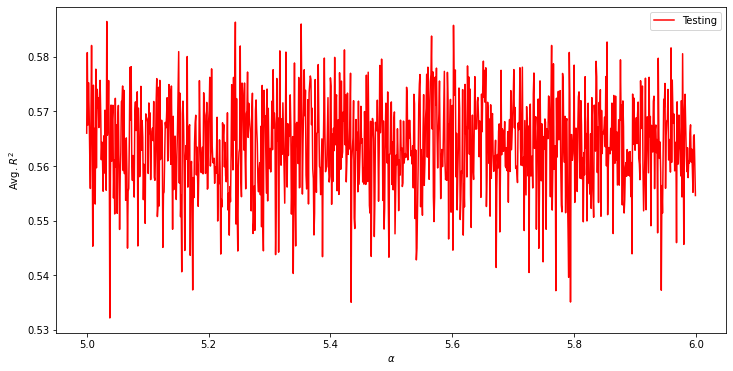

Highest training score, highest testing score, alpha: [0.6250613641790606, 0.5864529953481007, 5.033000000000011]


In [ ]:
compare_alpha(a_range,R2internal,R2external)

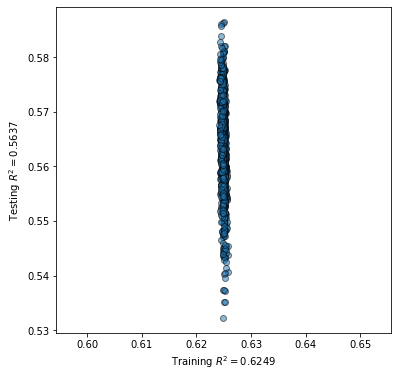

In [ ]:
plot_model_results(R2internal,R2external)

In [ ]:
# fit final model
idx_max = np.argmax(R2external)
model = Ridge(alpha=a_range[idx_max], fit_intercept=False)
R2train, R2test, MSEtrain, MSEtest = test_model(X.values,y.values,model,10,2)

In [ ]:
# calculate mean training, mean testing R^2
rid2 = [np.mean(R2train), np.mean(R2test)]
rid2

[0.6252166906699522, 0.5704819700051177]

### Lasso regularization

In [ ]:
#test range of alpha
a_range = np.arange(1e-3,0.02,0.0001) 
k = 10 

# track internal, external validation
R2internal = []
R2external = []
MSEinternal = []
MSEexternal = []

# test values of alpha
for a in a_range: 
  model = Lasso(alpha=a,fit_intercept=False)
  R2train_temp, R2test_temp, MSEtrain_temp, MSEtest_temp = test_model(X.values,y.values,model,k,2)
  R2internal.append(np.mean(R2train_temp))
  R2external.append(np.mean(R2test_temp))
  MSEinternal.append(np.mean(MSEtrain_temp))
  MSEexternal.append(np.mean(MSEtest_temp))

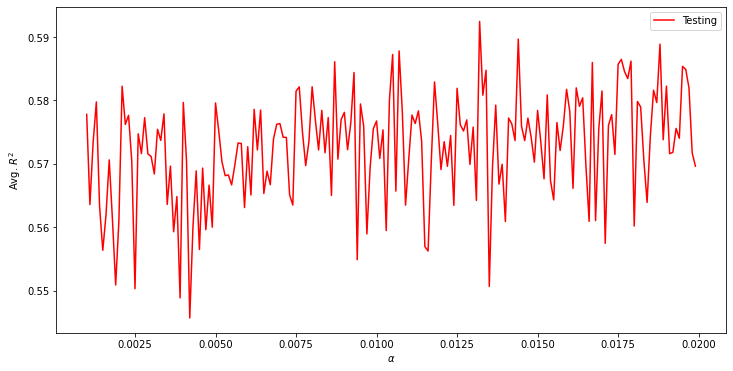

Highest training score, highest testing score, alpha: [0.6217231903818558, 0.5924599311589215, 0.013200000000000007]


In [ ]:
compare_alpha(a_range,R2internal,R2external)
alpha = a_range[idx_max]

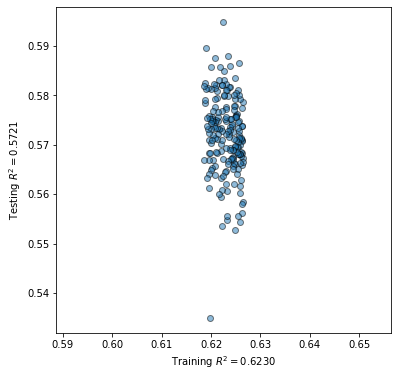

In [ ]:
plot_model_results(R2internal,R2external)

In [ ]:
# fit final model
idx_max = np.argmax(R2external)
model = Lasso(alpha=a_range[idx_max], fit_intercept=False)
R2train, R2test, MSEtrain, MSEtest = test_model(X.values,y.values,model,10,2)

In [ ]:
# calculate mean training, mean testing R^2
las2 = [np.mean(R2train), np.mean(R2test)]
las2

[0.6226544312203165, 0.574435822301876]

### Elastic Net regularization

In [ ]:
#test range of alpha
a_range = np.arange(1e-3,.2,0.01) 
k = 10 

# track internal, external validation
R2internal = []
R2external = []
MSEinternal = []
MSEexternal = []

# test values of alpha
for a in a_range: 
  model = ElasticNet(alpha=a,fit_intercept =False)
  R2train_temp, R2test_temp, MSEtrain_temp, MSEtest_temp = test_model(X.values,y.values,model,k,2)
  R2internal.append(np.mean(R2train_temp))
  R2external.append(np.mean(R2test_temp))
  MSEinternal.append(np.mean(MSEtrain_temp))
  MSEexternal.append(np.mean(MSEtest_temp))

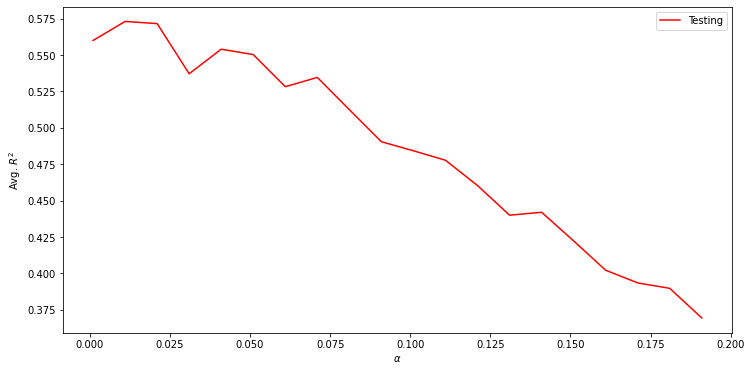

Highest training score, highest testing score, alpha: [0.6239067653631066, 0.5730920333932594, 0.011]


In [ ]:
compare_alpha(a_range,R2internal,R2external)

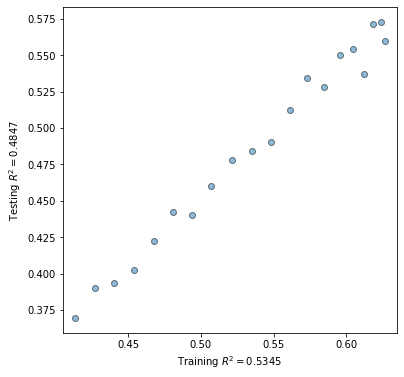

In [ ]:
plot_model_results(R2internal,R2external)

In [ ]:
# fit final model
idx_max = np.argmax(R2external)
model = ElasticNet(alpha=a_range[idx_max],fit_intercept=False)
R2train, R2test, MSEtrain, MSEtest = test_model(X.values,y.values,model,10,2)

In [ ]:
# calculate mean training, mean testing R^2
en2 = [np.mean(R2train), np.mean(R2test)]
en2

[0.6234578814051899, 0.5697258267878762]

## Degree = 3

### Ridge regularization

In [ ]:
#test range of alpha
#a_range = np.arange(36,38,0.01)
a_range = np.arange(0,20,.1) 
k = 10 

# track internal, external validation
R2internal = []
R2external = []
MSEinternal = []
MSEexternal = []

# test values of alpha
for a in a_range: 
  model = Ridge(alpha=a,fit_intercept=False)
  R2train_temp, R2test_temp, MSEtrain_temp, MSEtest_temp = test_model(X.values,y.values,model,k,3)
  R2internal.append(np.mean(R2train_temp))
  R2external.append(np.mean(R2test_temp))
  MSEinternal.append(np.mean(MSEtrain_temp))
  MSEexternal.append(np.mean(MSEtest_temp))

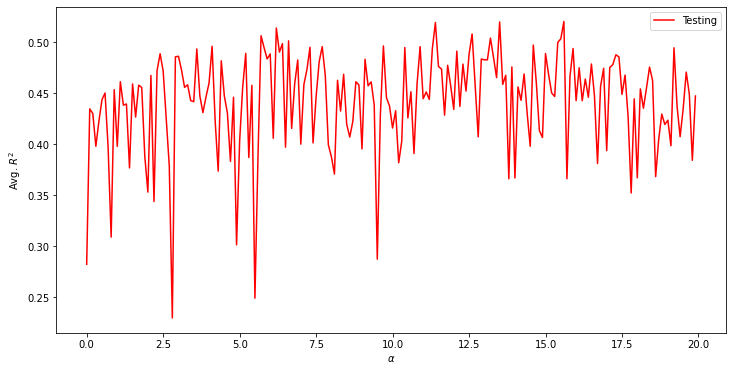

Highest training score, highest testing score, alpha: [0.694633281576076, 0.5202934761930458, 15.600000000000001]


In [ ]:
compare_alpha(a_range,R2internal,R2external)

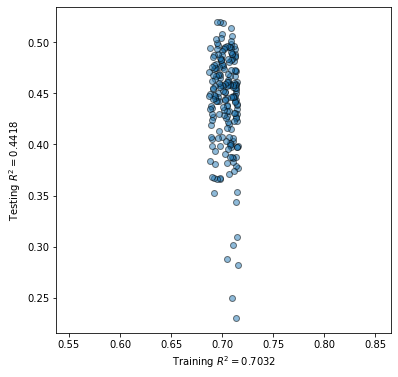

In [ ]:
plot_model_results(R2internal,R2external)

In [ ]:
# fit final model
idx_max = np.argmax(R2external)
model = Ridge(alpha=a_range[idx_max],fit_intercept=False)
R2train, R2test, MSEtrain, MSEtest = test_model(X.values,y.values,model,10,3)

In [ ]:
# calculate mean training, mean testing R^2
rid3 = [np.mean(R2train), np.mean(R2test)]
rid3

[0.6951107745597283, 0.3669912059656281]

### Lasso regularization

In [ ]:
#test range of alpha
a_range = np.arange(1e-3,.1,0.01) 
k = 10 

# track internal, external validation
R2internal = []
R2external = []
MSEinternal = []
MSEexternal = []

# test values of alpha
for a in a_range: 
  model = Lasso(alpha=a, max_iter=10000,fit_intercept=False)
  R2train_temp, R2test_temp, MSEtrain_temp, MSEtest_temp = test_model(X.values,y.values,model,k,3)
  R2internal.append(np.mean(R2train_temp))
  R2external.append(np.mean(R2test_temp))
  MSEinternal.append(np.mean(MSEtrain_temp))
  MSEexternal.append(np.mean(MSEtest_temp))

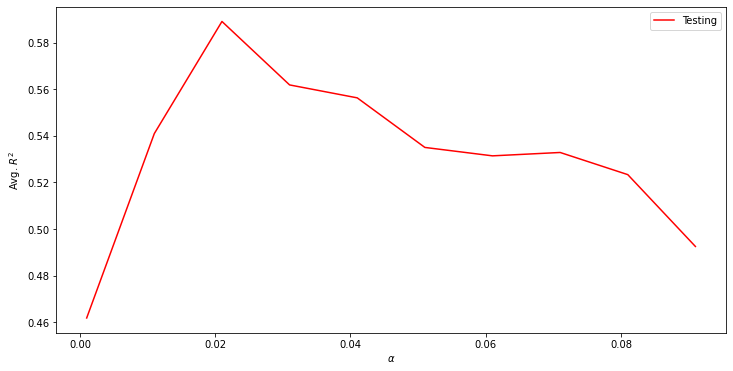

Highest training score, highest testing score, alpha: [0.6814342725459244, 0.5891102286745112, 0.020999999999999998]


In [ ]:
compare_alpha(a_range,R2internal,R2external)

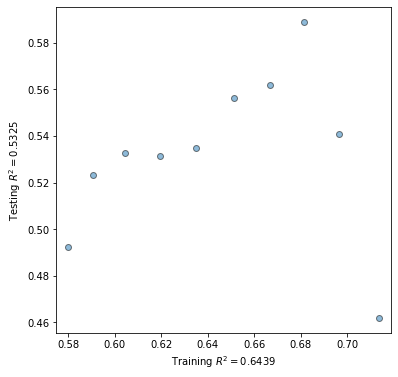

In [ ]:
plot_model_results(R2internal,R2external)

In [ ]:
# fit final model
idx_max = np.argmax(R2external)
model = Lasso(alpha=a_range[idx_max],fit_intercept=False)
R2train, R2test, MSEtrain, MSEtest = test_model(X.values,y.values,model,10,3)

In [ ]:
# calculate mean training, mean testing R^2
las3 = [np.mean(R2train), np.mean(R2test)]
las3

[0.682134481567673, 0.5645976938564831]

### Elastic Net regularization

In [ ]:
#test range of alpha
a_range = np.arange(1e-3,0.3,.01) 
k = 10 

# track internal, external validation
R2internal = []
R2external = []
MSEinternal = []
MSEexternal = []

# test values of alpha
for a in a_range: 
  model = ElasticNet(alpha=a, max_iter=10000,fit_intercept=False)
  R2train_temp, R2test_temp, MSEtrain_temp, MSEtest_temp = test_model(X.values,y.values,model,k,3)
  R2internal.append(np.mean(R2train_temp))
  R2external.append(np.mean(R2test_temp))
  MSEinternal.append(np.mean(MSEtrain_temp))
  MSEexternal.append(np.mean(MSEtest_temp))

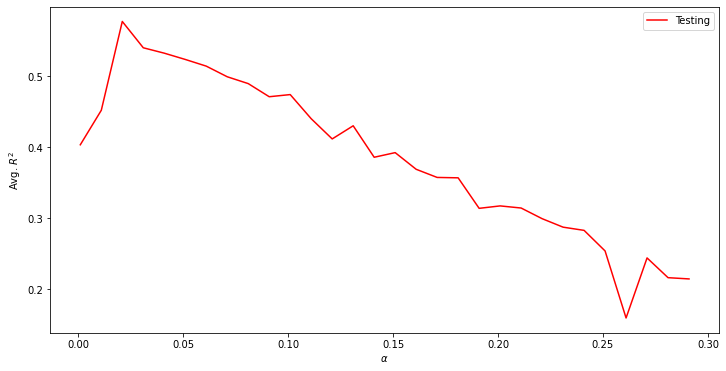

Highest training score, highest testing score, alpha: [0.6913905102793085, 0.5776799637280935, 0.020999999999999998]


In [ ]:
compare_alpha(a_range,R2internal,R2external)

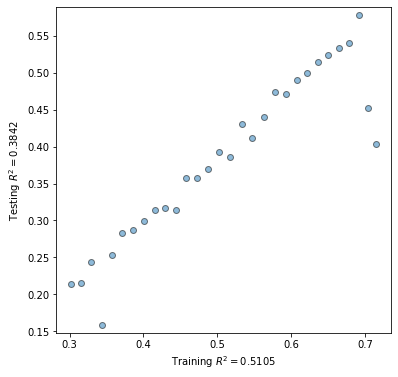

In [ ]:
plot_model_results(R2internal,R2external)

In [ ]:
# fit final model
idx_max = np.argmax(R2external)
model = ElasticNet(alpha=a_range[idx_max],fit_intercept=False)
R2train, R2test, MSEtrain, MSEtest = test_model(X.values,y.values,model,10,3)

In [ ]:
# calculate mean training, mean testing R^2
en3 = [np.mean(R2train), np.mean(R2test)]
en3

[0.6919386858609078, 0.5493411091399125]

## Results
Mean testing $\\R^2$ vs. mean training $\\R^2$

Polynomial model with degree = 2 and lasso regularization has the highest testing score of all models.

**Degree = 1**

In [ ]:
print(rid1)
print(las1)
print(en1)

[0.5713928819998757, 0.5501656549951657]
[0.5773465234169441, 0.565560900930541]
[0.5769473469557272, 0.5566029678902258]


**Degree = 2**

In [ ]:
print(rid2)
print(las2)
print(en2)

[0.6252166906699522, 0.5704819700051177]
[0.6226544312203165, 0.574435822301876]
[0.6234578814051899, 0.5697258267878762]


**Degree = 3**

In [ ]:
print(rid3)
print(las3)
print(en3)

[0.6951107745597283, 0.3669912059656281]
[0.682134481567673, 0.5645976938564831]
[0.6919386858609078, 0.5493411091399125]


# Tests for normality

Check if residuals are normally distributed.

### Refit Lasso model on polynomial features (degree = 2)

In [ ]:
scale = StandardScaler()
poly = PolynomialFeatures(degree=2)
pipe = Pipeline([['Scaler',scale],['Poly Feats',poly]])

xpoly = poly.fit_transform(X)

model = Lasso(alpha=alpha,fit_intercept=False)
model.fit(xpoly,y)
y_poly_pred = model.predict(xpoly)

### $\\R^2$ and MSE

In [ ]:
r2 = r2_score(y,y_poly_pred)
r2

0.606398117827279

In [ ]:
error = mse(y,y_poly_pred)
error

0.8331466296065373

### Quantile-Quantile plot

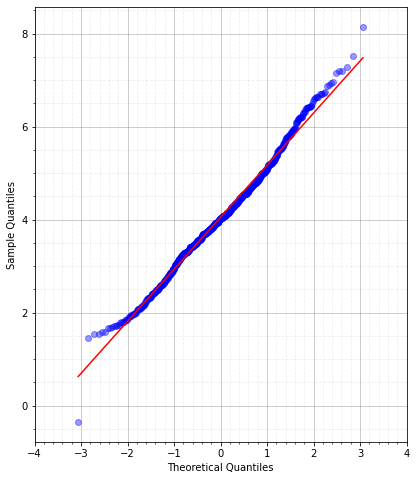

In [ ]:
N, M = 8,8
plt.rc("figure", figsize=(N,M))
plt.rcParams['axes.facecolor'] = 'white'
sm.qqplot(y_poly_pred.flatten(), loc = 0, scale = 1, line='s',alpha=0.4)
#sm.qqplot(y_poly_pred, loc = 0, scale = 1, line='s',alpha=0.4)
plt.xlim([-4,4])
#plt.ylim([-3,3])
plt.axes().set_aspect('equal')
plt.grid(b=True,which='major', color ='grey', linestyle='-', alpha=0.5)
plt.grid(b=True,which='minor', color ='grey', linestyle='--', alpha=0.15)
plt.minorticks_on()
plt.show()

### Histogram

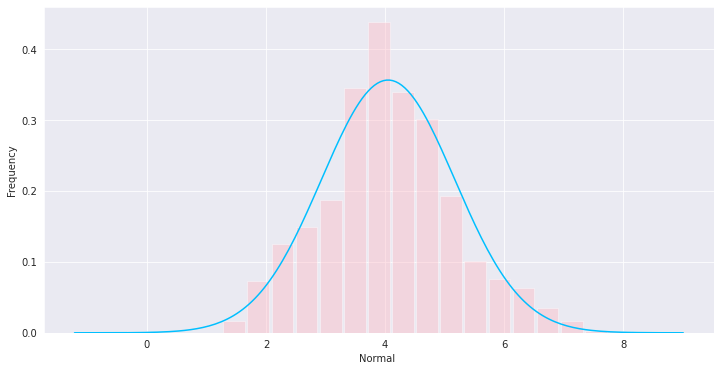

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
ax = sns.distplot(y_poly_pred,
                  bins=21,
                  kde=False,
                  color='deepskyblue',
                  hist_kws={"color":'lightpink', "rwidth": 0.9},
                  fit=stats.norm,
                  fit_kws={"color":'deepskyblue'})
ax.set( xlabel='Normal ', ylabel='Frequency')
sns.set_style("darkgrid")
ax.grid(fillstyle='full',c='white',zorder=1, which='major')
plt.show()

### Kolmorogov-Smirnoff, Anderson-Darling, Shapiro-Wilk Tests

In [ ]:
stats.kstest(y_poly_pred.flatten(),'norm')

KstestResult(statistic=0.948536207333309, pvalue=0.0)

In [ ]:
stats.anderson(y_poly_pred.flatten(),'norm')

AndersonResult(statistic=1.7194281850137259, critical_values=array([0.573, 0.653, 0.784, 0.914, 1.087]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

In [ ]:
stats.shapiro(y_poly_pred.flatten())

ShapiroResult(statistic=0.9929730296134949, pvalue=0.000274539808742702)

KS and Shapiro tests: Low p-values reject the null hypothesis. Normality assumption is violated by residuals.

Anderson test: Test statistic is greater than critical values at each significant level, so reject the null hypothesis.

The residuals of this model are not normally distributed.